# Working with Unstructured Meshes

This demo uses [meshmode](https://documen.tician.de/meshmode/).

In [46]:
import numpy as np
import numpy.linalg as la
import pyopencl as cl
import pyopencl.clmath
import meshmode.mesh.generation as mgen
from meshmode.discretization import Discretization
from meshmode.discretization.poly_element import PolynomialWarpAndBlendGroupFactory

import matplotlib.pyplot as plt

In [49]:
cl_ctx = cl.create_some_context(interactive=True)
queue = cl.CommandQueue(cl_ctx)

Choose platform:
[0] <pyopencl.Platform 'Portable Computing Language' at 0x7f7d74a9f5c0>
[1] <pyopencl.Platform 'Intel(R) OpenCL' at 0x195da28>


Choice [0]: 0


Set the environment variable PYOPENCL_CTX='0' to avoid being asked again.


In [168]:
order = 10

In [169]:
mesh = mgen.generate_icosphere(r=1, order=order, uniform_refinement_rounds=1)

discr = Discretization(cl_ctx, mesh,
        PolynomialWarpAndBlendGroupFactory(order))

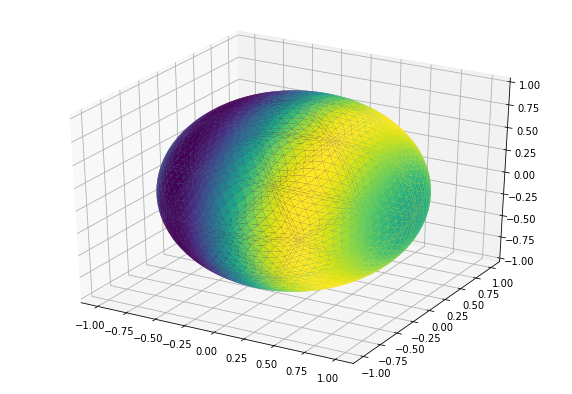

In [170]:
from meshmode.discretization.visualization import make_visualizer
vis = make_visualizer(queue, discr, order)

x, y, z = discr.nodes()
val = cl.clmath.sin(3*x.with_queue(queue))

plt.figure(figsize=(10, 7))
vis.show_scalar_in_matplotlib_3d(val, do_show=False)

In [171]:
grp = discr.groups[0]
val_view = grp.view(val.get(queue=queue))
nodes = grp.view(discr.nodes().get(queue=queue))

print(val_view.shape)
print(nodes.shape)

(80, 66)
(3, 80, 66)


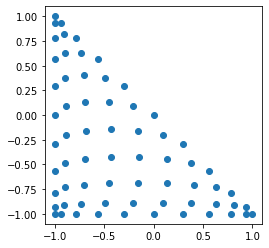

In [172]:
plt.plot(grp.unit_nodes[0], grp.unit_nodes[1], "o")
plt.gca().set_aspect("equal")

In [173]:
from modepy.matrices import vandermonde

vdm = vandermonde(grp.basis(), grp.unit_nodes)
dr_vdm, ds_vdm = vandermonde(grp.grad_basis(), grp.unit_nodes)

# Use la.solve in real code!
dr = dr_vdm @ la.inv(vdm)
ds = ds_vdm @ la.inv(vdm)

In [174]:
dr_nodes = np.einsum("ij,dkj->dki", dr, nodes)
ds_nodes = np.einsum("ij,dkj->dki", ds, nodes)

normals = np.cross(dr_nodes, ds_nodes, axisa=0, axisb=0, axisc=0)

area_elements = la.norm(normals, axis=0)

area = np.einsum("i, ki->", grp.weights, area_elements)

true_area = 4*np.pi
abs(area - true_area)/true_area

2.5275656016611805e-11